# Spotlight — lightFM
name: Yue Yang



# Introduction
LightFM is a Python implementation of a number of popular recommendation algorithms for both implicit and explicit feedback.

It also makes it possible to incorporate both item and user metadata into the traditional matrix factorization algorithms. It represents each user and item as the sum of the latent representations of their features, thus allowing recommendations to generalise to new items (via item features) and to new users (via user features).

# Installation

install from pip:

pip install lightfm

or Conda:

conda install -c conda-forge lightfm

# Implicit feedback

For some time, the recommender system literature focused on explicit feedback: the Netflix prize focused on accurately reproducing the ratings users have given to movies they watched.
Focusing on ratings in this way ignored the importance of taking into account which movies the users chose to watch in the first place, and treating the absence of ratings as absence of information.
But the things that we don’t have ratings for aren’t unknowns: we know the user didn’t pick them. This reflects a user’s conscious choice, and is a good source of information on what she thinks she might like.

This sort of phenomenon is described as data which is missing-not-at-random in the literature: the ratings that are missing are more likely to be negative precisely because the user chooses which items to rate. When choosing a restaurant, you only go to places which you think you’ll enjoy, and never go to places that you think you’ll hate. What this leads to is that you’re only going to be submitting ratings for things which, a priori, you expected to like; the things that you expect you will not like you will never rate.
This observation has led to the development of models that are suitable for implicit feedback. LightFM implements two that have proven particular successful:


# BPR: 
Bayesian Personalised Ranking [1] pairwise loss. Maximises the prediction difference between a positive example and a randomly chosen negative example. Useful when only positive interactions are present and optimising ROC AUC is desired.

# WARP: 
Weighted Approximate-Rank Pairwise [2] loss. Maximises the rank of positive examples by repeatedly sampling negative examples until rank violating one is found. Useful when only positive interactions are present and optimising the top of the recommendation list (precision@k) is desired.

# Getting the data
The first step is to get the Movielens data. This is a classic small recommender dataset, consisting of around 950 users, 1700 movies, and 100,000 ratings. The ratings are on a scale from 1 to 5, but we’ll all treat them as implicit positive feedback in this example.

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
 
from lightfm.datasets import fetch_movielens  
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score




In [15]:
data = fetch_movielens()

for key, value in data.items():
    print(key, type(value), value.shape)

train <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
test <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
item_features <class 'scipy.sparse.csr.csr_matrix'> (1682, 1682)
item_feature_labels <class 'numpy.ndarray'> (1682,)
item_labels <class 'numpy.ndarray'> (1682,)


In [55]:
train_df = pd.DataFrame(data['train'].todense(), columns=data['item_labels'])  # each row：user， each col：movie
print(train_df.head())

   Toy Story (1995)  GoldenEye (1995)  Four Rooms (1995)  Get Shorty (1995)  \
0               5.0               3.0                4.0                3.0   
1               4.0               0.0                0.0                0.0   
2               0.0               0.0                0.0                0.0   
3               0.0               0.0                0.0                0.0   
4               0.0               0.0                0.0                0.0   

   Copycat (1995)  Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)  \
0             3.0                                                5.0      
1             0.0                                                0.0      
2             0.0                                                0.0      
3             0.0                                                0.0      
4             0.0                                                0.0      

   Twelve Monkeys (1995)  Babe (1995)  Dead Man Walking (1995)  \
0       

In [17]:
train_df = train_df.transpose()
print(train_df.head())

                   0    1    2    3    4    5    6    7    8    9    ...  933  \
Toy Story (1995)     5    4    0    0    0    4    0    0    0    4  ...    2   
GoldenEye (1995)     3    0    0    0    0    0    0    0    0    0  ...    4   
Four Rooms (1995)    4    0    0    0    0    0    0    0    0    0  ...    0   
Get Shorty (1995)    3    0    0    0    0    0    5    0    0    4  ...    5   
Copycat (1995)       3    0    0    0    0    0    0    0    0    0  ...    0   

                   934  935  936  937  938  939  940  941  942  
Toy Story (1995)     3    4    0    4    0    0    5    0    0  
GoldenEye (1995)     0    0    0    0    0    0    0    0    5  
Four Rooms (1995)    0    4    0    0    0    0    0    0    0  
Get Shorty (1995)    0    0    0    0    0    2    0    0    0  
Copycat (1995)       0    0    0    0    0    0    0    0    0  

[5 rows x 943 columns]


Text(0.5, 0, 'count of rated')

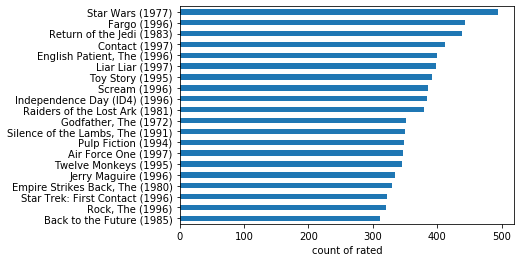

In [29]:
def count_label(x):
    if x > 0:
        return True
    else:
        return False

item_count = train_df.applymap(count_label).sum(axis=1)
item_count.sort_values(ascending=False)[0: 20][:: -1].plot.barh()  #plot the top 20 number of rated movie
plt.xlabel('count of rated')


In [22]:
train = data['train']
test = data['test']

# Train a BPR model 

In [28]:
model = LightFM(learning_rate=0.05, loss='bpr')
model.fit(train, epochs=10)
 
train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()
#expressing the percentage of top k items in the ranking the user has actually interacted with
train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()
#the probability that any known positive is higher on the list than a random negative example
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))


Precision: train 0.58, test 0.10.
AUC: train 0.89, test 0.85.


# Train a WARP model

In [36]:
model = LightFM(learning_rate=0.05, loss='warp')
model.fit_partial(train, epochs=30)
 
train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()
 

train_auc = auc_score(model, train).mean()  
test_auc = auc_score(model, test).mean()
 
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))


Precision: train 0.64, test 0.11.
AUC: train 0.95, test 0.91.


# Compare
To compare the accuracy between the WARP and BPR losses. Let’s fit two models with equivalent hyperparameters and compare their accuracy across epochs. Whilst we’re fitting them, let’s also measure how much time each epoch takes.

In [30]:
import time
alpha = 1e-05
epochs = 70
num_components = 32

warp_model = LightFM(no_components=num_components,
                    loss='warp',
                    learning_schedule='adagrad',
                    max_sampled=100,
                    user_alpha=alpha,
                    item_alpha=alpha)

bpr_model = LightFM(no_components=num_components,
                    loss='bpr',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

warp_duration = []
bpr_duration = []
warp_auc = []
bpr_auc = []

for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train, epochs=1)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, test, train_interactions=train).mean())

for epoch in range(epochs):
    start = time.time()
    bpr_model.fit_partial(train, epochs=1)
    bpr_duration.append(time.time() - start)
    bpr_auc.append(auc_score(bpr_model, test, train_interactions=train).mean())

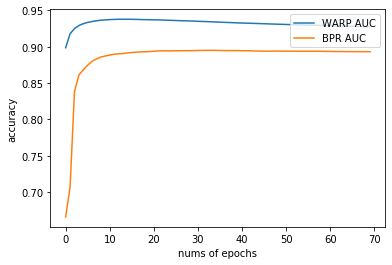

In [33]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.plot(x, np.array(bpr_auc))
plt.legend(['WARP AUC', 'BPR AUC'], loc='upper right')
plt.xlabel("nums of epochs")
plt.ylabel("accuracy")
plt.show()

Plotting the results immediately reveals that WARP produces superior results: a smarter way of selecting negative examples leads to higher quality rankings. Test accuracy decreases after the first 10 epochs, suggesting WARP starts overfitting and would benefit from regularization or early stopping.

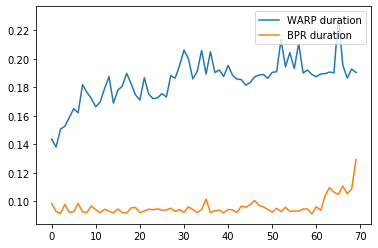

In [34]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_duration))
plt.plot(x, np.array(bpr_duration))
plt.legend(['WARP duration', 'BPR duration'], loc='upper right')
plt.show()

WARP is slower than BPR for all epochs. Interestingly, however, it gets slower with additional epochs; every subsequent epoch takes more time. This is because of WARP’s adaptive samlping of negatives: the closer the model fits the training data, the more times it needs to sample in order to find rank-violating examples, leading to longer fitting times.

# Recommendation
we can sample a couple of users and get their recommendations. To make predictions for given user, we pass the id of that user and the ids of all products we want predictions for into the predict method.

In [53]:
def sample_recommendation(model, data, user_ids):
    

    n_users, n_items = data['train'].shape

    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        
        scores = model.predict(user_id, np.arange(n_items))
        top_items = data['item_labels'][np.argsort(-scores)]
        
        print("User %s" % user_id)
        print("     Known positives:")
        
        for x in known_positives[:5]:
            print("        %s" % x)

        print("     Top recommend:")
        
        for x in top_items[:5]:
            print("        %s" % x)
        
sample_recommendation(warp_model, data, [9, 50, 750])

User 9
     Known positives:
        Toy Story (1995)
        Get Shorty (1995)
        Dead Man Walking (1995)
        Seven (Se7en) (1995)
        Usual Suspects, The (1995)
     Top recommend:
        GoodFellas (1990)
        English Patient, The (1996)
        Godfather, The (1972)
        Raiders of the Lost Ark (1981)
        Raising Arizona (1987)
User 50
     Known positives:
        Star Wars (1977)
        Citizen Kane (1941)
        Mr. Smith Goes to Washington (1939)
        Die Hard (1988)
        Empire Strikes Back, The (1980)
     Top recommend:
        Princess Bride, The (1987)
        Empire Strikes Back, The (1980)
        Star Wars (1977)
        Singin' in the Rain (1952)
        Indiana Jones and the Last Crusade (1989)
User 750
     Known positives:
        Toy Story (1995)
        GoldenEye (1995)
        Four Rooms (1995)
        Twelve Monkeys (1995)
        Seven (Se7en) (1995)
     Top recommend:
        Princess Bride, The (1987)
        Empire Strikes Ba

# Reference

[1] Rendle, Steffen, et al. “BPR: Bayesian personalized ranking from implicit feedback.” Proceedings of the Twenty-Fifth Conference on Uncertainty in Artificial Intelligence. AUAI Press, 2009.

[2] Weston, Jason, Samy Bengio, and Nicolas Usunier. “Wsabie: Scaling up to large vocabulary image annotation.” IJCAI. Vol. 11. 2011.